# Deep Neural Network with Tensorflow (Clinical Remission)

This pipeline has now been optimised for production deployment.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import shap
import json

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import datetime
from tensorflow.keras.metrics import AUC


from utils.data import load_and_preprocess_data
from utils.constants import NUMERICAL_FEATURES, RANDOM_SEED
from src.visualization.plotting import (
    plot_training_validation_auc,
    plot_training_validation_loss,
    plot_roc_curve,
)

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pipeline Configuration

In [2]:
random_seed = RANDOM_SEED  # Random seed to ensure reproducibility

output_path = "output/dnn_clinical_remission/"
cmap = "seismic"
file_prefix = "clin_remission"
df = load_and_preprocess_data()
df = df[df["has_active_symptoms"] == 0]

In [3]:
print(len(df))

362


## Data Loading

In [4]:
# Optimisation for production
# We removed low value features here and simplified the model

columns_to_drop = [
    "has_active_symptoms",
    "baseline_eims_arthralgia_arthritis",
    "baseline_eims_ankylosing_spondylitis",
    "baseline_eims_erythema_nodosum",
    "baseline_eims_uveitis",
    "baseline_eims_scleritis_episclerities",
    "is_smoker_smokeryn1",
    "study_group_name_Await Dx",
    "ifx_drug_level",
    "ada_drug_level",
    "ifx_drug_level_present",
    "ada_drug_level_present",
    "ifx_antibody_present",
    "ada_antibody_present",
    "haematocrit",
]

df.drop(columns=columns_to_drop, inplace=True)

numerical_features = NUMERICAL_FEATURES
numerical_features = [
    col
    for col in numerical_features
    if col not in ["haematocrit", "ada_drug_level", "ifx_drug_level"]
]

## Create Train Validate Test Datasets

In [5]:
# First split into train and temp 70% train, 30% temp which will be split 50:50 into 15% val and 15% test

# GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.36, n_splits=1, random_state=random_seed)

# Perform the split
for train_idx, test_idx in splitter.split(df, groups=df["study_id"]):
    train_data = df.iloc[train_idx]
    temp_data = df.iloc[test_idx]

# Drop 'study_id' from X_train and X_test as it's not a feature
X_train = train_data.drop(columns=["fatigue_outcome", "study_id"])
y_train = train_data["fatigue_outcome"]

groups = train_data["study_id"]  # Group variable for GroupKFold cross-validation

temp_data_splitter = GroupShuffleSplit(
    test_size=0.56, n_splits=1, random_state=random_seed
)

# Perform the split
for val_idx, test_idx in temp_data_splitter.split(
    temp_data, groups=temp_data["study_id"]
):
    val_data = df.iloc[val_idx]
    test_data = df.iloc[test_idx]

X_val = val_data.drop(columns=["fatigue_outcome", "study_id"])
y_val = val_data["fatigue_outcome"]

X_test = test_data.drop(columns=["fatigue_outcome", "study_id"])
y_test = test_data["fatigue_outcome"]


print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)
print("Y train shape:", y_train.shape)
print("Y val shape:", y_val.shape)
print("Y test shape:", y_test.shape)

Train shape: (243, 64)
Val shape: (55, 64)
Test shape: (64, 64)
Y train shape: (243,)
Y val shape: (55,)
Y test shape: (64,)


## Scale Numerical Features

In [6]:
X_unified = pd.concat([X_train, X_val, X_test])
unified_scaler = StandardScaler()
unified_scaler.fit(X_unified[numerical_features])

X_train[numerical_features] = unified_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = unified_scaler.transform(X_test[numerical_features])
X_val[numerical_features] = unified_scaler.transform(X_val[numerical_features])

## Deep Learning with TensorFlow


### Model Definition

In [7]:
model = keras.Sequential(
    [
        layers.Dense(324, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(100, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

### Compiling the Model

In [8]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[AUC()])

In [9]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback],
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5167 - loss: 0.6297 - val_auc: 0.7307 - val_loss: 0.4161
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.7333 - loss: 0.4684 - val_auc: 0.8225 - val_loss: 0.3776
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8236 - loss: 0.4444 - val_auc: 0.8128 - val_loss: 0.3455
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8669 - loss: 0.3988 - val_auc: 0.8116 - val_loss: 0.3417
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8773 - loss: 0.4082 - val_auc: 0.8176 - val_loss: 0.3288
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9045 - loss: 0.3412 - val_auc: 0.8370 - val_loss: 0.3105
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.9056 - loss: 0.3636 - val_auc: 0.8623 - val_loss: 0.2949
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9309 - loss: 0.2930 - val_auc: 0.8466 - val_loss: 0.2890
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9212 - loss: 0.3209 - val_auc

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 324)            │        21,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 324)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        32,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,324 (419.24 KB)

 Trainable params: 53,661 (209.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,663 (209.62 KB)

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])

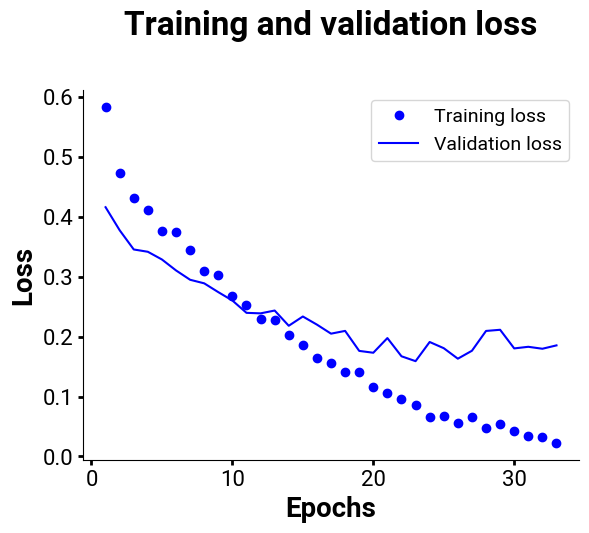

In [12]:
plot_training_validation_loss(history_dict, output_path, file_prefix)

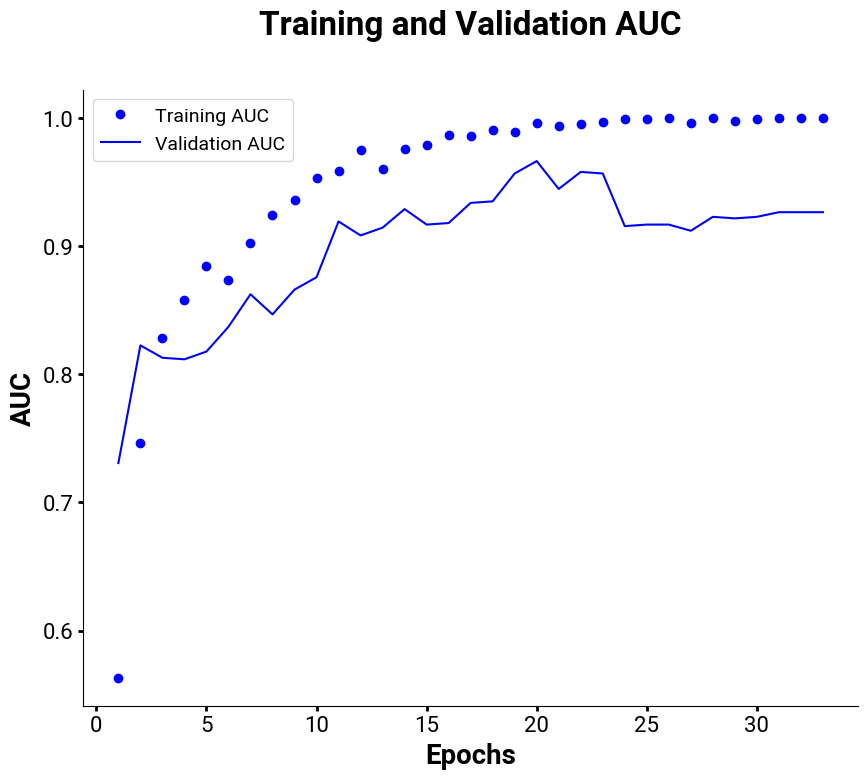

In [13]:
plot_training_validation_auc(history_dict, output_path, file_prefix)

In [14]:
results = model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.8759 - loss: 0.4759


In [15]:
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    recall_score,
)

y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred)

y_classes = np.where(y_pred > 0.5, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, y_classes).ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_classes)
sensitivity = recall_score(y_test, y_classes)  # TPR
specificity = tn / (tn + fp)  # TN

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUC:", test_auc)

metrics_dictionary = {
    "accuracy": accuracy,
    "sensitivity": sensitivity,
    "specificity": specificity,
    "auc": test_auc,
}

with open(output_path + "dnn_metrics.json", "w") as f:
    json.dump(metrics_dictionary, f)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy: 0.90625
Sensitivity: 0.7727272727272727
Specificity: 0.9761904761904762
AUC: 0.8863636363636364


In [16]:
np.savetxt(output_path + "dnn_fpr.txt", fpr)
np.savetxt(output_path + "dnn_tpr.txt", tpr)

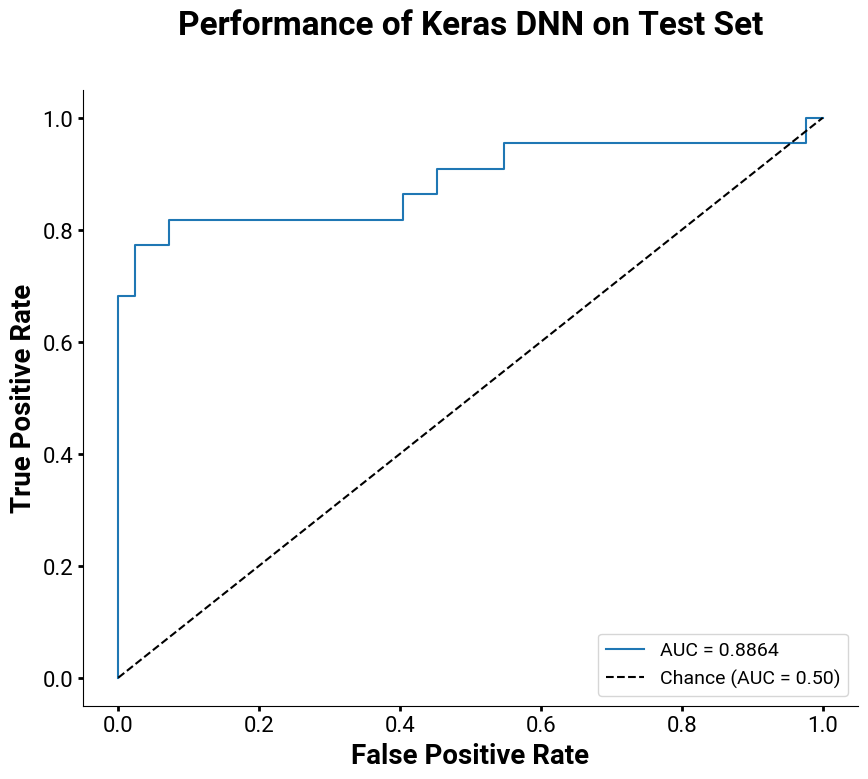

In [17]:
plot_roc_curve(fpr, tpr, test_auc, output_path, file_prefix)

## SHAP Analysis on Keras DNN Model

In [18]:
# Clean Column Names for Graphs

X_test_clean_columns = [
    col.replace("montreal_cd_location_", " ") for col in X_test.columns
]
X_test_clean_columns = [col.replace("_", " ") for col in X_test_clean_columns]
X_test_clean_columns = [
    col.replace("montreal uc extent ", "") for col in X_test_clean_columns
]
X_test_clean_columns = [
    col.replace("montreal uc severity ", "") for col in X_test_clean_columns
]
X_test_clean_columns = [
    col.replace("montreal cd behaviour ", "") for col in X_test_clean_columns
]
X_test_clean_columns = [col.replace("is smoker ", "") for col in X_test_clean_columns]
X_test_clean_columns = [col.replace("name ", "") for col in X_test_clean_columns]
# to title case
X_test_clean_columns = [col.title() for col in X_test_clean_columns]
replacements = {
    "Uc": "UC",
    "Cd": "CD",
    "Ibdu": "IBDU",
    "Bmi": "BMI",
    "Crp": "CRP",
    "Gi": "GI",
}

for old, new in replacements.items():
    X_test_clean_columns = [col.replace(old, new) for col in X_test_clean_columns]
print(X_test_clean_columns)

['Age', 'Sex', 'Height', 'Weight', 'BMI', 'Age At Diagnosis', 'Montreal Upper GI', 'Montreal Perianal', 'Albumin', 'CRP', 'Haemoglobin', 'Red Cell Count', 'White Cell Count', 'Neutrophils', 'Lymphocytes', 'Monocytes', 'Eosinophils', 'Basophils', 'Platelets', 'Urea', 'Creatinine', 'Sodium', 'Potassium', 'Calprotectin', 'Sampling Steroids', 'Sampling Abx', 'Sampling Asa', 'Sampling Aza', 'Sampling Mp', 'Sampling Ifx', 'Sampling Ada', 'Sampling Vedo', 'Sampling Uste', 'Sampling Tofa', 'Sampling Mtx', 'Sampling Ciclosporin', 'Sampling Filgo', 'Sampling Upa', 'Sampling Risa', 'Disease Duration Weeks', 'Diagnosis Year', 'Study Group CD', 'Study Group IBDU', 'Study Group UC', ' L1 Ileal', ' L2 Colonic', ' L3 Ileocolonic', 'B1 Non-Stricturing, Non-Penetrating', 'B2 Stricturing', 'B3 Penetrating', 'E1 Proctitis', 'E2 Left-Sided', 'E3 Extensive', 'S0 Remission', 'S1 Mild', 'S2 Moderate', 'S3 Severe', 'Ex-Smoker', 'Non-Smoker', 'Smoker', 'Season Autumn', 'Season Spring', 'Season Summer', 'Season 

In [19]:
explainer = shap.KernelExplainer(
    model, shap.sample(X_train, 200, random_state=random_seed)
)
shap_values = explainer.shap_values(X_test)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 64/64 [00:48<00:00,  1.33it/s]


In [20]:
shap.initjs()

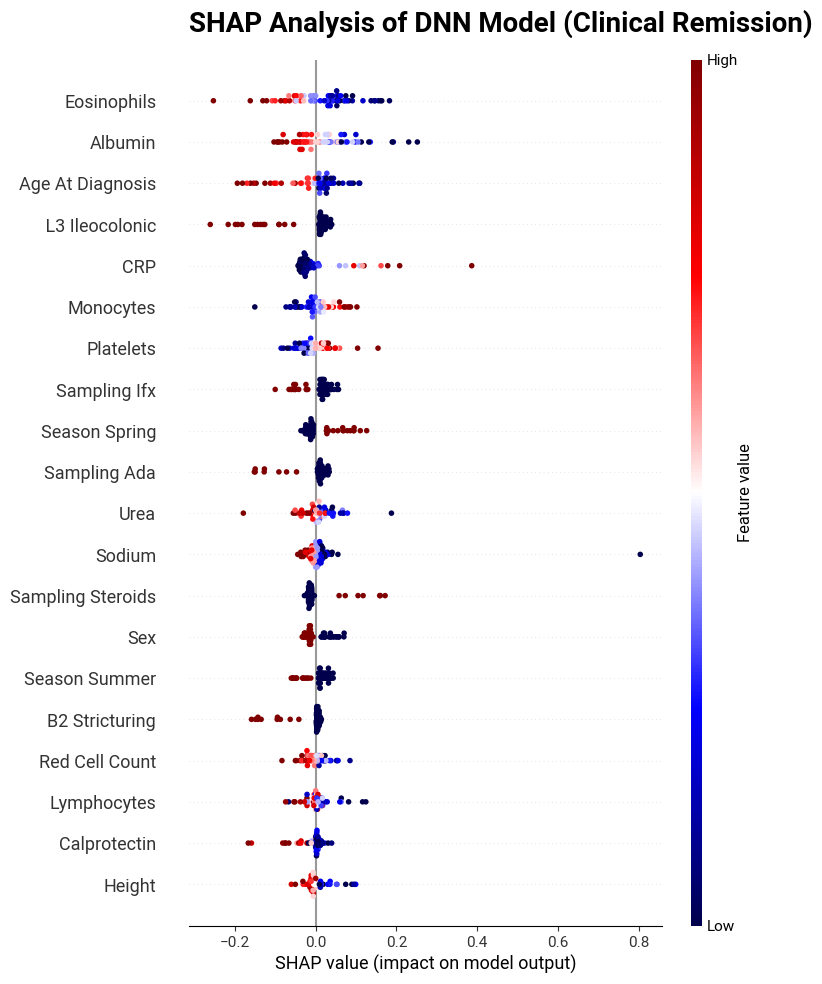

In [21]:
shap_values_class_1 = shap_values[:, :, 0]
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test_clean_columns,
    show=False,
    cmap=cmap,
)

plt.title(
    "SHAP Analysis of DNN Model (Clinical Remission)",
    fontsize=20,
    pad=20,
    loc="left",
    fontweight="bold",
)

save_path = f"{output_path}shap_dnn.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

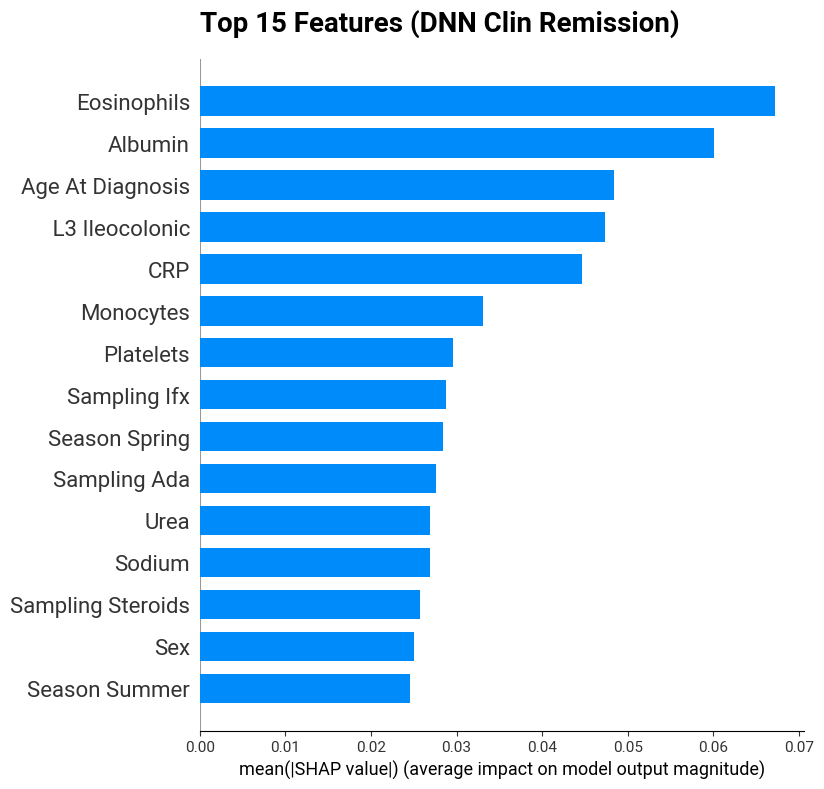

In [22]:
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test_clean_columns,
    show=False,
    cmap=cmap,
    plot_type="bar",
    max_display=15,
)

plt.title(
    "Top 15 Features (DNN Clin Remission)",
    fontsize=20,
    pad=20,
    loc="left",
    fontweight="bold",
)
plt.yticks(fontsize=16)

save_path = f"{output_path}shap_dnn_barplot.png"
plt.savefig(save_path, dpi=600, bbox_inches="tight")
plt.show()

In [23]:
X_test_reverted = X_test

In [24]:
X_test_reverted[numerical_features] = unified_scaler.inverse_transform(
    X_test[numerical_features]
)

In [25]:
X_test_reverted[numerical_features] = X_test_reverted[numerical_features].round(2)

In [26]:
# Find corrrect and incorrect predictions

outcomes = pd.concat([y_test, pd.Series(y_classes.ravel(), index=y_test.index)], axis=1)
outcomes.columns = ["true", "predicted"]


In [27]:
correct_predictions = outcomes[outcomes["true"] == outcomes["predicted"]]
correct_predictions = correct_predictions.join(X_test_reverted)
incorrect_predictions = outcomes[outcomes["true"] != outcomes["predicted"]]
incorrect_predictions = incorrect_predictions.join(X_test_reverted)

incorrect_predictions.to_csv(output_path + "incorrect_predictions.csv", index=False)
correct_predictions.to_csv(output_path + "correct_predictions.csv", index=False)

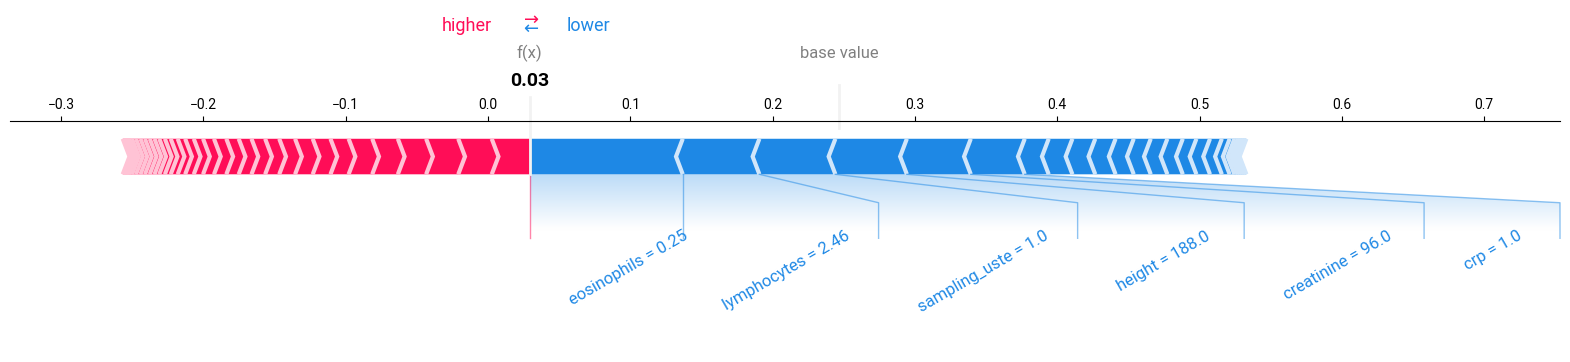

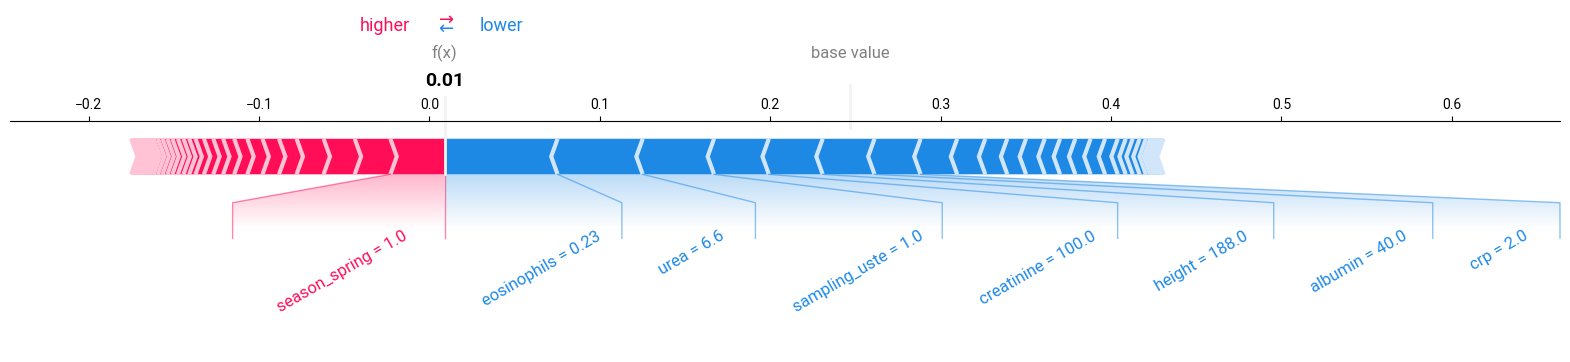

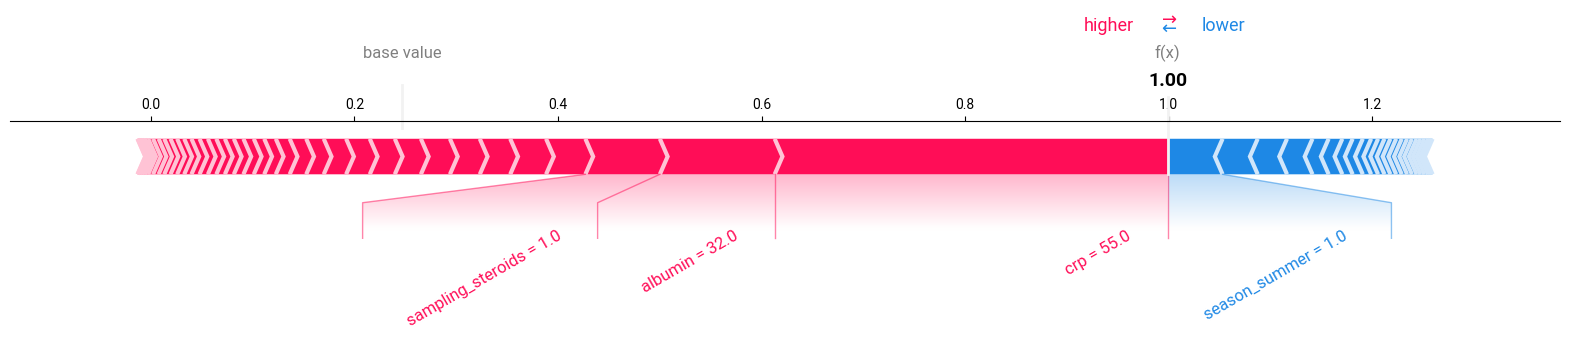

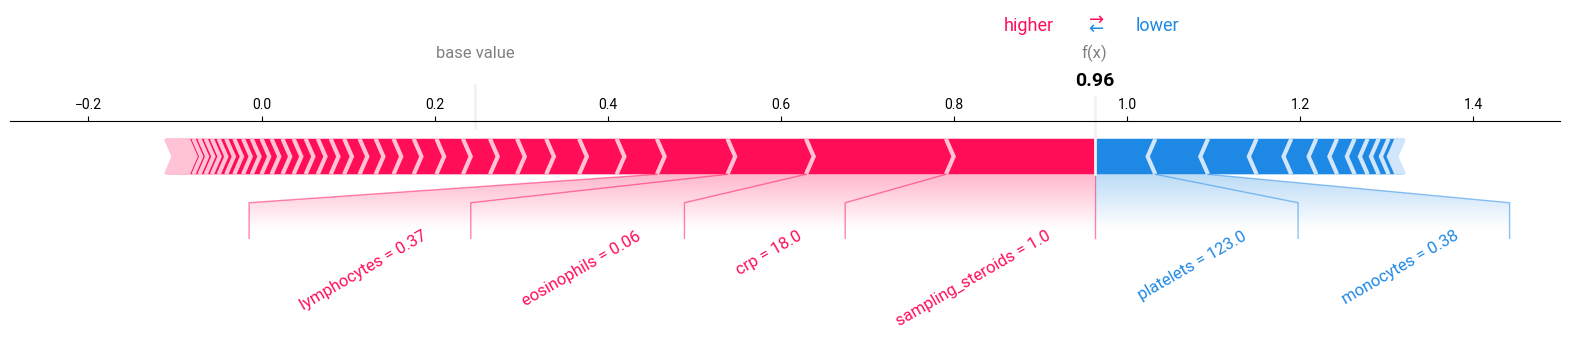

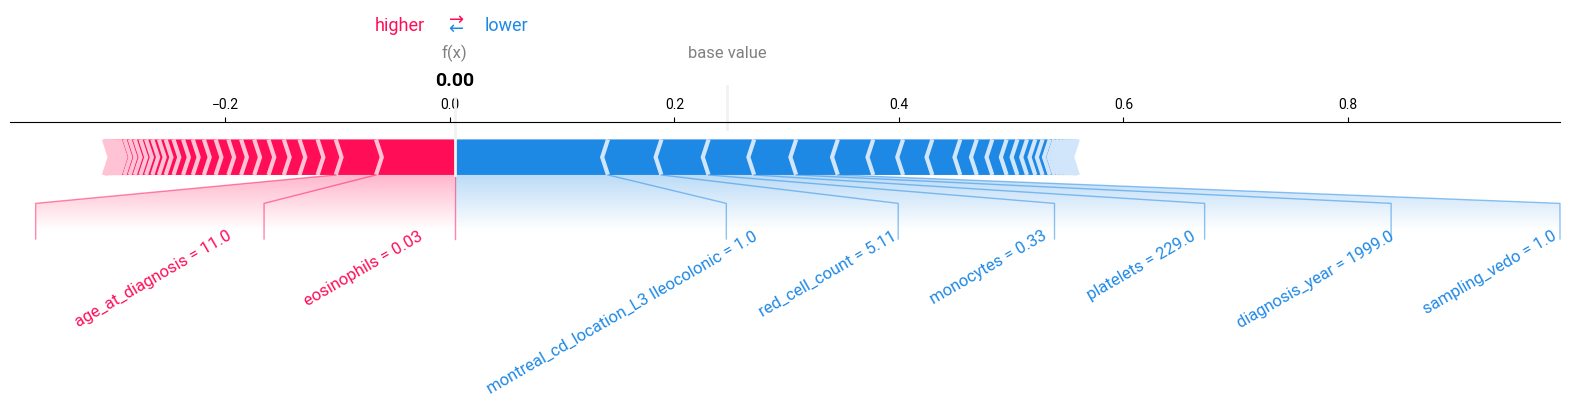

In [28]:
shap_values_correct_predictions = pd.DataFrame(shap_values_class_1, index=y_test.index)
shap_values_correct_predictions = shap_values_correct_predictions.loc[
    correct_predictions.index
]
shap_values_correct_predictions = shap_values_correct_predictions.to_numpy()
X_test_reverted_correct_predictions = X_test_reverted.loc[correct_predictions.index]
X_test_reverted_correct_predictions.reset_index(inplace=True)
X_test_reverted_correct_predictions.drop(columns=["index"], inplace=True)

number_of_incorrect_predictions = 5  # len(shap_values_incorrect_predictions) # Uncomment to run all incorrect predictions

for i in range(number_of_incorrect_predictions):
    shap.force_plot(
        explainer.expected_value[0],
        shap_values_correct_predictions[i],
        X_test_reverted_correct_predictions.iloc[i],
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )

    save_path = f"{output_path}forceplot_correct_{i}.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

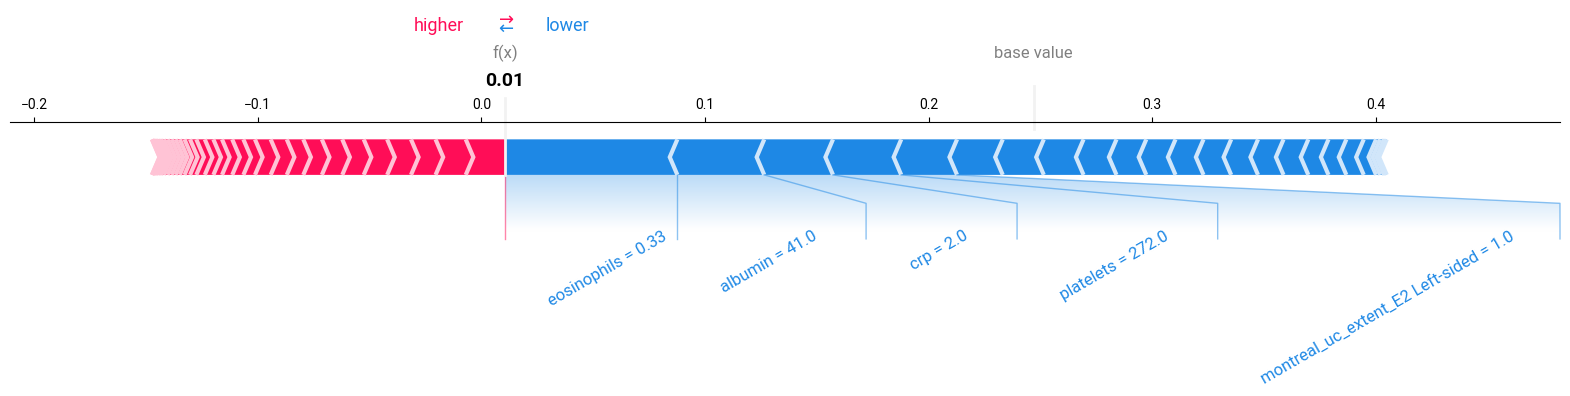

In [29]:
shap_values_incorrect_predictions = pd.DataFrame(
    shap_values_class_1, index=y_test.index
)
shap_values_incorrect_predictions = shap_values_incorrect_predictions.loc[
    incorrect_predictions.index
]
shap_values_incorrect_predictions = shap_values_incorrect_predictions.to_numpy()
X_test_reverted_incorrect_predictions = X_test_reverted.loc[incorrect_predictions.index]
X_test_reverted_incorrect_predictions.reset_index(inplace=True)
X_test_reverted_incorrect_predictions.drop(columns=["index"], inplace=True)

number_of_incorrect_predictions = 1  # len(shap_values_incorrect_predictions) # Uncomment to run all incorrect predictions

for i in range(number_of_incorrect_predictions):
    shap.force_plot(
        explainer.expected_value[0],
        shap_values_incorrect_predictions[i],
        X_test_reverted_incorrect_predictions.iloc[i],
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )

    save_path = f"{output_path}forceplot_incorrect_{i}.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

## Production Exports

In [30]:
# import pickle
# from joblib import dump

# today = datetime.datetime.now().strftime("%Y-%m-%d")

# dump(unified_scaler, output_path + f"export/scaler_{today}.pkl")
# # X_train.to_csv(output_path + "export/X_train.csv", index=False)
# X_test.to_csv(output_path + "export/X_test.csv", index=False)
# model.save(f"{output_path}export/fatigue_model_{today}.keras")
# with open(output_path + f"export/shap_explainer_{today}.pkl", "wb") as f:
#     pickle.dump(explainer, f)